What's better than the ability to pull up to class lounging on a pool float?
Enjoy lounging on a pool float, but want to use it outside a swimming pool?
Or perhaps you just want some cool swag utility vehicle (SUV) for fun?

## Article Note

This article is quite old and was pulled from my high school / college writing archive. Expect errors and issues with the content.

## Pool Float Car

What's better than the ability to pull up to class lounging on a pool float?
Enjoy lounging on a pool float, but want to use it outside a swimming pool?
Or perhaps you just want some cool swag utility vehicle (SUV) for fun?



If any of those descriptions above suits you, I've got you covered!

[via GIPHY](https://giphy.com/gifs/summer-beach-tens-3orif11wPHwyScjG5W)

The goal of this post is to explain this project and how I plan on
accomplishing it!

This pool float car is extremely simple in construction. It consists of a
three-wheeled design for cost reduction and simplicity.

A frame will be made of wood (for easier machinability). On top of this frame,
the pool float will be attached.

Two fixed-direction wheels support the front of the mobile. These motors will
not be powered.

One wheel upon a steering mechanism will be present in the back of the mobile.
This wheel will be a hub motor, similar to those commonly seen on commonly-
available electric scooters such as the Xiaomi M365. Steering will be
implemented by mounting this motor on the rotor of a turntable. This turntable
will be turned via a stepper motor.

The stator of the electric steering system will be mounted to the bottom of
the rear of the mobile's frame. This stator will contain a stepper motor with
a small spur gear, which mates with a large spur gear manufactured directly
upon the rotor of the steering system. A potentiometer will be added to allow
the computer to calibrate and center the steering at boot.

The design of the steering system allows the mobile to turn in place with a
steering angle of 90 degrees! Do doughnuts without even trying!

## Drive Wheel and Steering Electronics

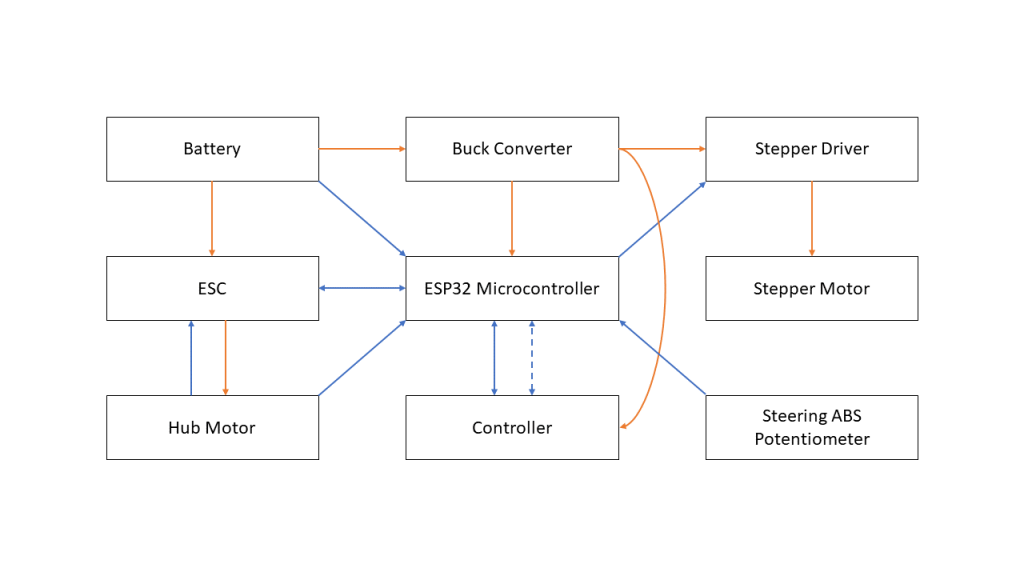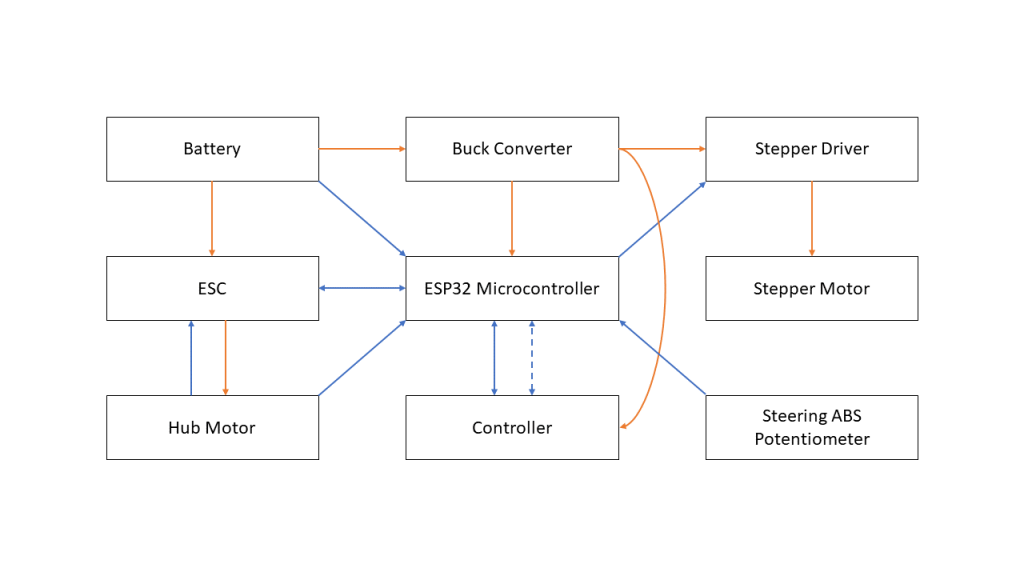

Orange arrows represent power connections; Blue arrows represent communication channels;
Solid blue represents wired communication; Dashed blue represents wireless
communication

The main SoC used in this design will be the ESP32 (showin in the middle), a
dual-core microcontroller with the Xtensa architecture. This microcontroller
will be connected to the controller via a wired signal connection (blue solid
arrow) and a wireless link (dashed blue arrow).

The SoC can read the battery voltage for safe low-voltage cutoff and high-
voltage regen cutoff. The SoC will be communicate power, brake and regen with
the ESC. The ESC will drive the hub motor, using hall sensors for commutation
feedback.

The SoC will be connected to a stepper driver to move the steering column, and
a potentiometer to measure the absolute (although not precise) steering angle.

Depending on the complexity of the control protocol with the

## Controller Electronics

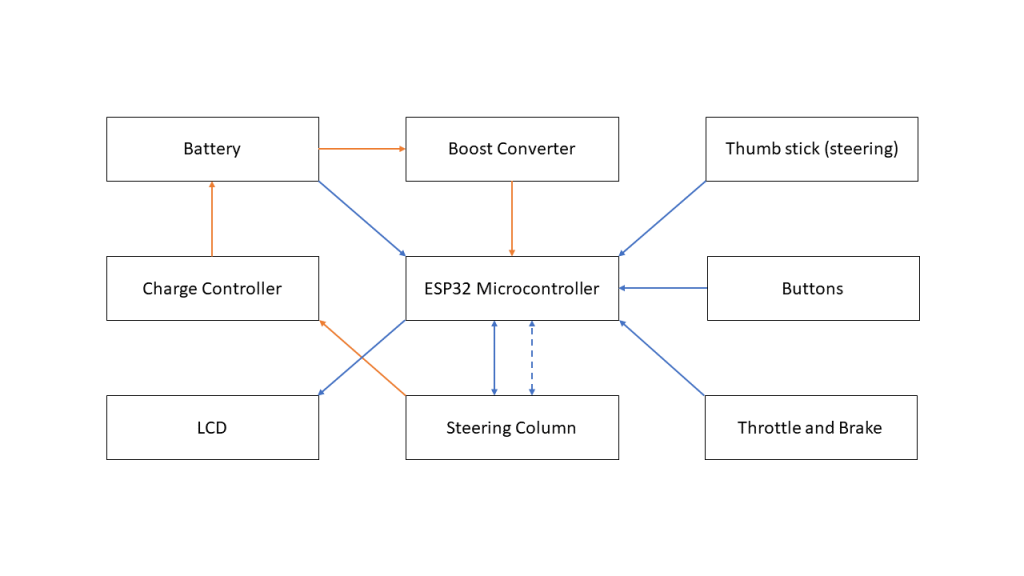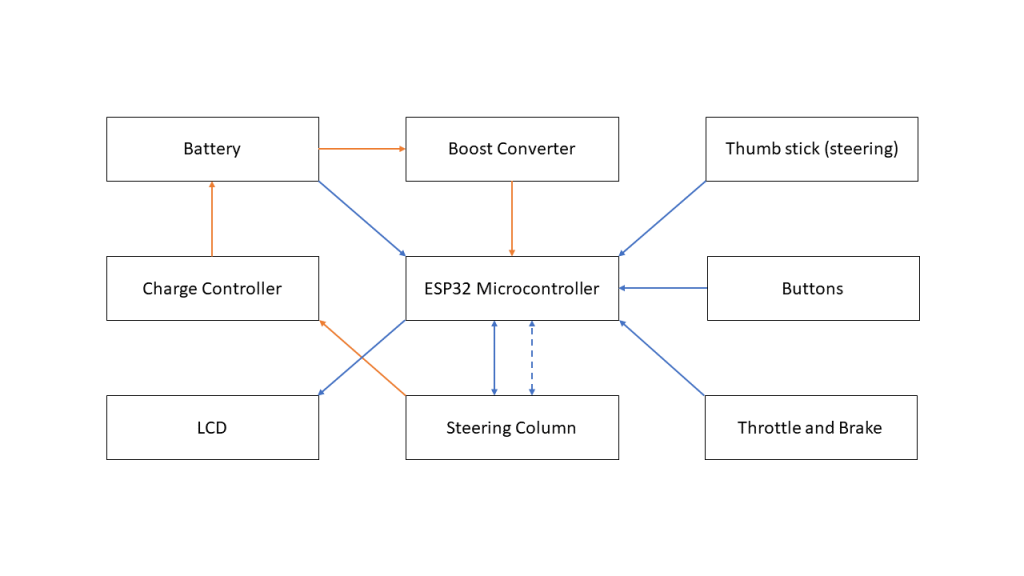

Orange arrows represent power connections; Blue arrows represent communication channels;
Solid blue represents wired communication; Dashed blue represents wireless
communication

The controller is designed similarly to the drive wheel and steering control
system. The peripherals connected to the SoC are the LCD, and the controls
used to control the mobile.

The LCD shows information such as speed, charge status, connection status,
drive mode, instantaneous torque, and other important information.

The X-axis of the thumb stick will be used for steering. The Y-axis may be
used for throttle / brake, although those will likely be another control.

Buttons will be used to navigate the menus, control the mobile (change drive
modes, etc.) and act as a power switch for the controller and the drive wheel
and steering control system.

## Wired Communications Electronics

Wired communications will use the SPI protocol for maximum performance. A mclk
of 5 MHz will be used, allowing for 5 Mb/s link performance. To support hot-
plug, when a wired link is not established, the steering control system will
pull up the MISO pin. The controller will connect the MISO pin to GND (low).
When the controller is plugged into the steering control system, the MISO pin
will be driven low which should wake up the steering control system. The
steering control system shall now set MOSI to LOW, which should be pulled HIGH
by the controller. This should wake the controller up to initiate
reconnection.

To allow for hot-unplug, if two or more packets are lost (20 ms), the link
will be considered broken and a wireless command will be established.

If the controller is unplugged while the mobile is driving at a speed higher
than 1 MPH, the mobile will E-stop.

## Wireless Communications Electronics

The wireless communications will use the ESP32's built in support for WiFi. No
extra electronics are necessary, except possibly a high-gain 2.4 GHz antenna
with an IPEX connector.

## Communications Protocol

Communications will use packets, individual pieces of information that are
separate from each other. Wired packets will be slightly different from
wireless packets. Wireless packets will be encrypted using AES-CTR 128 bit
(explained later). The encrypted payload of the wireless packets will be
similar to the wired packets. All packets can be represented by a packed
structure.

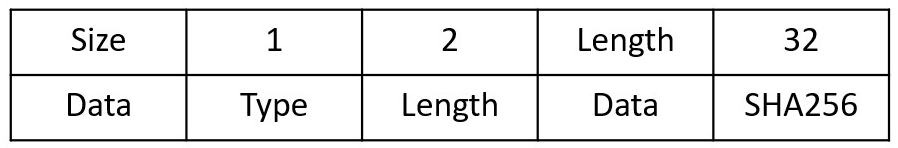Wired
protocol packet description

The diagram above shows what a wired packet looks like. It includes a packet
type, a payload length, a payload, and a hash (may be a different hash) to
verify integrity.

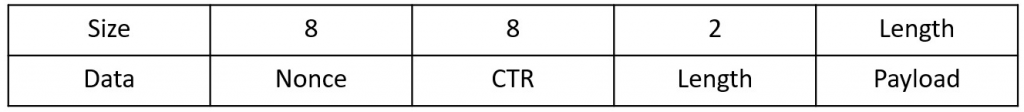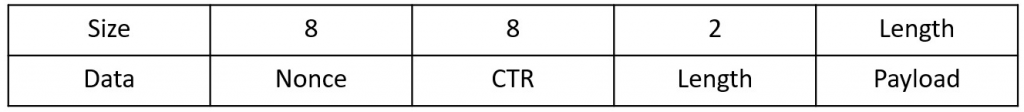

Wireless protocol packet description

The payload of above wireless packets is a wired packet encrypted with AES-CTR
128-bit.

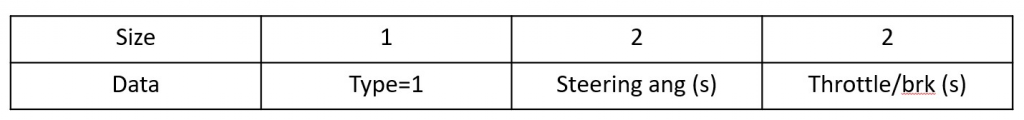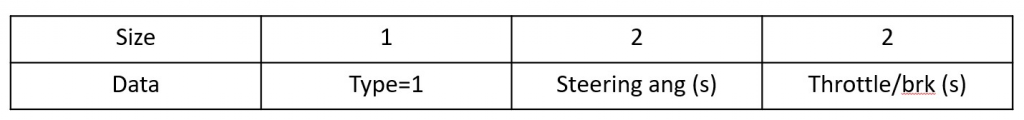

Throttle/Steering Update Packet

The subpacket above (payload in the packet) updates the steering angle
(signed, maps between -90 deg to 90 deg) and the throttle (signed, maps
between 100% brake and 100% throttle). This subpacket has a type, 1. This
packet is sent from the controller to the steering control system.

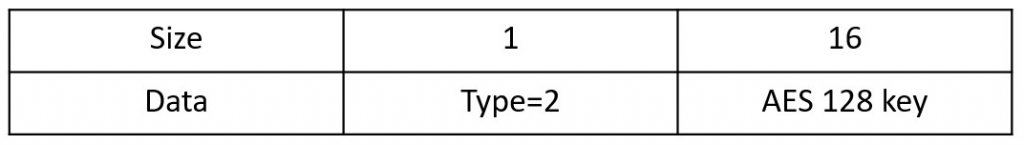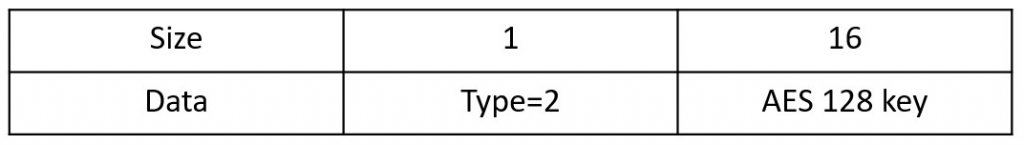

Key negotiation packet

The subpacket above, with type 2, negotiates an AES 128 bit key for secure,
encrypted wireless communications with the AES-CTR 128-bit cipher.

As this project is developed, more subpackets will emerge. They will be
explained in future articles.

## Curveballs

This wouldn't be a project by Yash without some curveballs!

The steering column needs to be entirely 3D printed using a small delta 3D
printer. This requires much more care as I need to manage the stress on the
plastics in all situations. I might even need to 3D print low-speed disk/drum
brakes to engage when the drive motor is too slow to brake
electromagnetically.

Technically encryption is not necessary for this project because who will are
about hacking this?! I'm using encryption because it is forcing me to learn
how to properly use AES, choose the correct cipher for the job and implement
it securely.

I need to minimize latency over WiFi.

### 3D Printing the Entire Thing

The rotor is designed to be as small as possible to fit the required parts,
but as large enough to fit in my printer by diameter to maximize the volume
supporting the wheel mount.

The stator will be either printed in multiple pieces then glued together with
super glue, or printed on a school printer (yeah, I hate the lead time) which
can print it in one go.

### Lower-Level Communications Protocol and Security

To skip the bulk of having a heavy IP stack, I will be transmitting and
receiving raw packets via the 802.11 baseband. This will hopefully reduce the
connection latency.

Of course, we have the issue that security is no longer implemented for us via
WPA2. We gotta secure ourselves!!!

For this project, the wired connection is being considered as a secure
channel. Through this secure channel, a pre-shared key (PSK), 128 bits of
length is shared to allow for secure communication via AES-CTR 128-bit.

All packets received with the correct MAC header will be "decrypted" using the
key, nonce and CTR (counter). The end of each message is a hash. If the
message does not match the hash, the message will be discarded.

To prevent replay attacks, the highest-received CTR will be tracked. If a
packet is received with a CTR below the highest recorded CTR, it will be
discarded. The CTR, while sent unencrypted, cannot be modified, because
modifying the nonce or CTR would cause decryption to fail, and the packet to
be discarded.

If replay attacks become a huge issue ever, a timestamp can be sent with each
packet. The clock would be synced every time the controller is connected via a
wired connection.

### Encryption

The communications protocol I am using is lossy. Most AES ciphers work on
streams of continuous data. Missing pieces of data must be retransmitted to
decrypt later bits of data.

We are sending a ton of extremely short packets. If we use the same AES key
over-and-over again with most ciphers, we slowly expose our key more and more.
Stream ciphers allow the same AES key to encrypt multiple blocks by mixing in
data from the previous block, fudging the relationship between the plaintext
and ciphertext for the block being encrypted. Thus, we need the previous block
to decrypt the next block.

We can "change" the AES key used for every encryption/decryption by specifying
parameters for an "initialization vector," which can be viewed as a salt for
the encryption key.

Instead of using the bare AES key to perform the encryption and decryption, we
derive a new working AES key by applying a different initialization vector
every time we encrypt. This is how we accomplish this:

Our initialization vector is the same length as the AES PSK. For us, this is
128 bits. We initialize this IV on the sender with a random number. This is
called the nonce (number used once). Generally, with AES-CTR, we only fill the
bottom 64 bits with the random number, and the upper 64 bits with the counter
(or some other split). Instead, this project will implement the nonce using a
128 bit random number for initialization.

To allow the sender and receiver to use the same AES PSK, the controller will
increment the nonce for every encrypted block. The steering column will
decrement the nonce every time a block is encrypted. Note that each side will
track its own nonce, and this won't get updated when data is received.